In [26]:
import numpy as np

def compute_eigenbasis(i, mat):
    """
    i-th eigenbasis
    """
    U, S, Vt = np.linalg.svd(mat, full_matrices=False)
    u_i = U[:, i].reshape(-1, 1)
    v_i = Vt[i, :].reshape(1, -1)
    eigenbasis = np.dot(u_i, v_i)
    return eigenbasis

In [27]:

# d = 20
# rows, cols = d//2, d

# # Generate a random matrix
# random_matrix = np.random.rand(rows, cols)
# row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
# random_matrix = random_matrix / row_norms


# # top eigenspace, for example
# _ = compute_eigenbasis(0, random_matrix)

# U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
# kappa = S[0]/S[-1]
# print(kappa)

In [28]:
# Generate a poorly conditioned random matrix, enforce "halfing" eigenvalue sequence

d = 1000
col = d

kappa = 1/d**2 # want this to be "poly d"
s = [1]
while s[-1] > 2 * kappa:
  s += [s[-1]/2]

row = len(s)

# generate a random basis, U of dimension row x row

U_rand = np.random.randn(row, row)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
U, _ = np.linalg.qr(U_rand)

V_rand = np.random.randn(col, row)
V, _ = np.linalg.qr(V_rand)

random_matrix = np.dot(np.dot(U, np.diag(s)), V.T)
row_norms = np.linalg.norm(random_matrix, axis=1, keepdims=True)  # Compute row-wise norms
random_matrix = random_matrix / row_norms

U, S, Vt = np.linalg.svd(random_matrix, full_matrices=False)
print(S[0]/S[-1]) # see the damage caused by normalizing

522228.3378999352


In [29]:
# Kaczmarz
def kaczmarz(iter, mat, b=0, random=True, n=10):
  """ 
    Kaczmarz Algorithm (equal norm rows): 
      1. sample row from `mat' at random
      2. remove the projection of iterate x along this row

    [iter: number of iterations], [mat: matrix],
    [random: random initialization of x_0 on the sphere], [n: add iterates to tracking list every `n` iterations]
  """
  # start with initial guess
  row, col = mat.shape[0], mat.shape[1]
  x = np.random.rand(col)
  x = x/np.linalg.norm(x)


  iterates = []
  # pick a random row of the matrix
  for i in range(iter):
    a_i = mat[np.random.randint(0, row), :]
    x = x + (b - np.inner(a_i, x))/(np.linalg.norm(a_i)**2) * a_i
    if i % n == 0:
      iterates += [x]
  return iterates

In [30]:
def conjugate_gradient(iter, mat, b=None, random=True, n=10):
    row, col = mat.shape

    # Ensure b is a (row,1) column vector
    if b is None:
        b = np.zeros((row, 1))
    
    # Ensure x is a (col,1) column vector
    x = np.random.rand(col, 1)
    x = x / np.linalg.norm(x)

    iterates = [x]
    r = b - np.matmul(mat, x)
    p = r
    print("Initial p shape:", p.shape)  # Should be (row,1)

    for i in range(iter):
        alpha = np.linalg.norm(r) ** 2 / np.matmul(p.T, np.matmul(mat, p))
        x = x + alpha * p  # x should stay (col,1)

        new_r = r - alpha * np.matmul(mat, p)  # residual
        beta = (np.linalg.norm(new_r) ** 2) / (np.linalg.norm(r) ** 2)
        p = new_r + beta * p
        r = new_r

        if i % n == 0:
            iterates.append(x)

    return iterates

In [31]:
import matplotlib.pyplot as plt

# if proj_iterates has r rows (for each eigenvalue) and t columns (for each iterate), visualize the first k using "top k"
# visiualize just the last row (bottom eigenspace) using min_k = 1000000 and top_k= 1000000 (some large numbers)
def plot_projections(proj_iterates, min_k=0, top_k=3, n=10, title="Title Missing"):
    nums = [i * n for i in range(len(proj_iterates[0]))]

    # Define a color map for distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, top_k))

    plt.figure(figsize=(8, 6))  # Set figure size

    if min_k > len(proj_iterates):
        min_k = len(proj_iterates) - 1
        
    for k in range(min_k, min(len(proj_iterates), top_k)):
        plt.plot(nums, [proj_iterates[k][i] for i in range(len(proj_iterates[0]))],
                 color=colors[k], label=f"Eigenvector {k+1}", linewidth=2)

    plt.xlabel("Iterations")
    plt.ylabel("Projection")
    plt.legend(title="Eigenspace")  # Add legend title
    plt.title(title)
    plt.show()

    return 0


In [32]:
steps = 500
iterates = kaczmarz(steps, random_matrix, n=1)
print(len(iterates))

# best rank k approx; top k eigenbases
rank_k = [compute_eigenbasis(k, random_matrix) for k in range(S.shape[0])]
# print(rank_k[0].shape)

# project the iterates onto each of the eigenspaces
normalized_iterates = [iterates[i]/np.linalg.norm(iterates[i]) for i in range(len(iterates))]
proj_iterates = [[np.linalg.norm(np.matmul(rank_k[k], normalized_iterates[i])) for i in range(len(normalized_iterates))] for k in range(len(rank_k))]
print(len(proj_iterates), len(proj_iterates[0]))

500
20 500


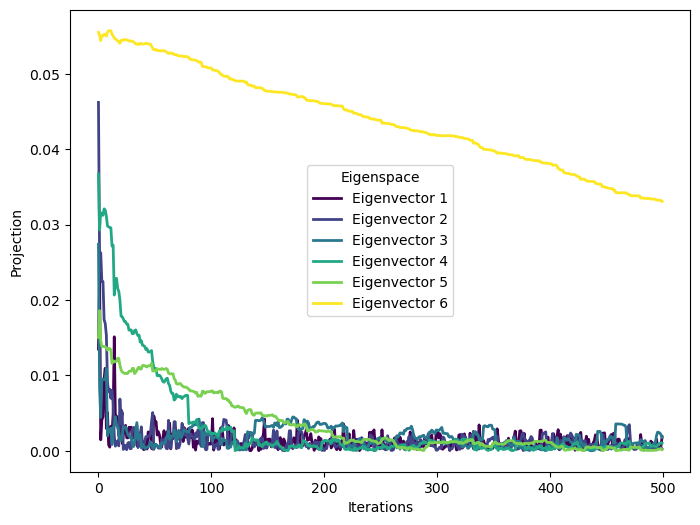

0

In [33]:
# to smooth iterates
def moving_average(data, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(data, window, 'same')

smoothed = [
    moving_average(proj_iterates[k], 20) for k in range(len(rank_k))
]
# plot progress (put a very large number for top_k to see all eigenvalues)
# plot_projections(smoothed, top_k=6, n=1)
plot_projections(proj_iterates, min_k=0, top_k=100000, n=1)

Think about a matrix $A \in \mathbb{R}^{4 \times 4}$ with eigenvalues $(1, 1, 1/\kappa, 1/\kappa)$. So, $$ A = v_1 v_1 ^\top + v_2 v_2 ^\top  + \frac{1}{\kappa} (v_3 v_3 ^\top + v_4 v_4^\top)$$
where $v_i$ are mutually orthogonal unit eigenvectors. Think about $A$ as a mixture of projections orthogonal to $T = \text{span}(v_1, v_2)$ and $B = \text{span}(v_3, v_4)$, its top and bottom subspaces.



In [53]:
kappa = 5
depth = 4

eig = np.array([[1/(kappa ** i), 1/(kappa ** i)] for i in range(depth//2)]).ravel()
S = np.diag(eig)

V_rand = np.random.randn(depth, depth)  # d x d matrix with normal distribution

# Perform QR decomposition to obtain an orthonormal basis
V, _ = np.linalg.qr(V_rand)

A = np.dot(V, np.dot(S, V.T))
row_norms = np.linalg.norm(A, axis=1, keepdims=True)  # Compute row-wise norms
A = A / row_norms


U, S, Vt = np.linalg.svd(A, full_matrices=False)
print(S)
print(U)
print(Vt.T)

[1.47761721 1.28616522 0.30257491 0.26622327]
[[-0.65883735  0.01931962 -0.74830119  0.07486948]
 [-0.06283765  0.76258872  0.01060596 -0.64373705]
 [-0.44976929 -0.56176481  0.31982976 -0.61630903]
 [-0.59974359  0.32016481  0.58106951  0.44739284]]
[[-0.6301237   0.01704394 -0.77167438  0.0846893 ]
 [-0.07197151  0.78953618  0.00932814 -0.60939783]
 [-0.46989347 -0.53530853  0.30235961 -0.63342211]
 [-0.61397423  0.29964463  0.55947324  0.46929568]]


In [38]:
# # Sadly, normalizing rows destroys the nice structure :(
# V_1, V_2 = V[:, :2], V[:, 2:]   # principal and minor eigenspace
# print(V_1.shape, V_2.shape)
# x = np.random.rand(4)
# x = x/np.linalg.norm(x)
# print("This norm is significant: ", np.linalg.norm(np.dot(A, x) - (np.dot(np.dot(V_1, V_1.T), x) + 1/kappa * np.dot(np.dot(V_2, V_2.T), x))))

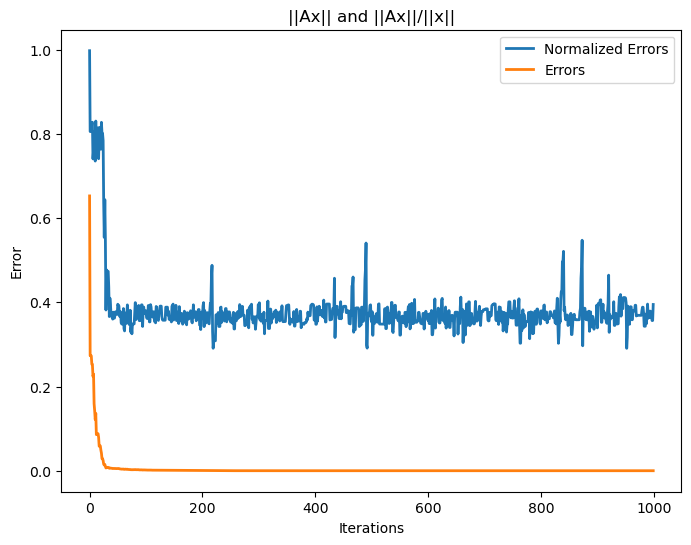

[0.6542617164994624, 0.3389011102270886, 0.3389011102270886, 0.3389011102270886, 0.30536613723323147, 0.30532187423341994, 0.30251255614501865, 0.3021145611416419, 0.19758383508322838, 0.18220483257077144, 0.16554213739190426, 0.16387442599305696, 0.11455361704987445, 0.1083811087985028, 0.10823997196678953, 0.10814815725213696, 0.10742292077421815, 0.07247817287581423, 0.0723721526129522, 0.0723721526129522, 0.06436022597823653, 0.05059006383446739, 0.035674095965974956, 0.035674095965974956, 0.031013551815702083, 0.024595445919006562, 0.02429629945220993, 0.02325166478869397, 0.018712148141347078, 0.01714967625404489, 0.016956850799096278, 0.01694228862420775, 0.016941195071016688, 0.01694111298521709, 0.016143793394940625, 0.015820224256846004, 0.015797328260537355, 0.015629259129164616, 0.01558266466273438, 0.015564358199490072, 0.015557174864563551, 0.01450477962620688, 0.014460019320709817, 0.014460019320709817, 0.014448647625898856, 0.014444186656709454, 0.013431208709562938, 0.

In [51]:
steps = 1000
b = 0 # np.random.randn(1)

iterates = kaczmarz(steps, A, b=b, n=1)

errors = [np.linalg.norm(np.dot(A, iterates[i])) for i in range(len(iterates))]

normalized_iterates = [iterat/np.linalg.norm(iterat) for iterat in iterates]
normalized_errors = [np.linalg.norm(np.matmul(A, normalized_iterates[i])) for i in range(len(normalized_iterates))]

norms = [np.linalg.norm(iterates[i]) for i in range(len(iterates))]
nums = [i for i in range(len(iterates))]

smoothed_normalized_errors = moving_average(normalized_errors, 20)
smoothened_errors = moving_average(errors, 20)

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, normalized_errors, label=f"Normalized Errors", linewidth=2)
plt.plot(nums, errors, label=f"Errors", linewidth=2)
plt.title("||Ax|| and ||Ax||/||x||")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

print(norms)

In [40]:
# full rank case
print(kappa)
print(normalized_errors[-10])
print("balanced between T, B: ", 1/kappa * 1 + (1 - 1/kappa) * 1/kappa)



5
0.3546436930590861
balanced between T, B:  0.36


[0.01762304 0.29704186 0.88915254 0.29176417]


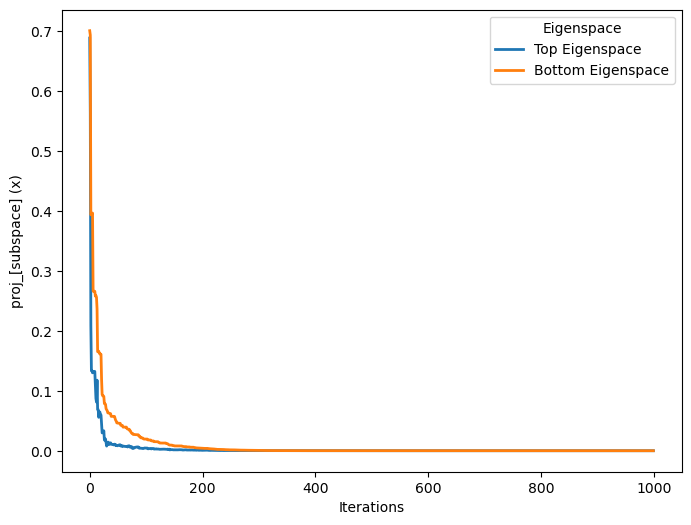

In [41]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)

print(iterates[0])

# Projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in iterates]

# Projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")

plt.xlabel("Iterations")
plt.ylabel("proj_[subspace] (x)")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

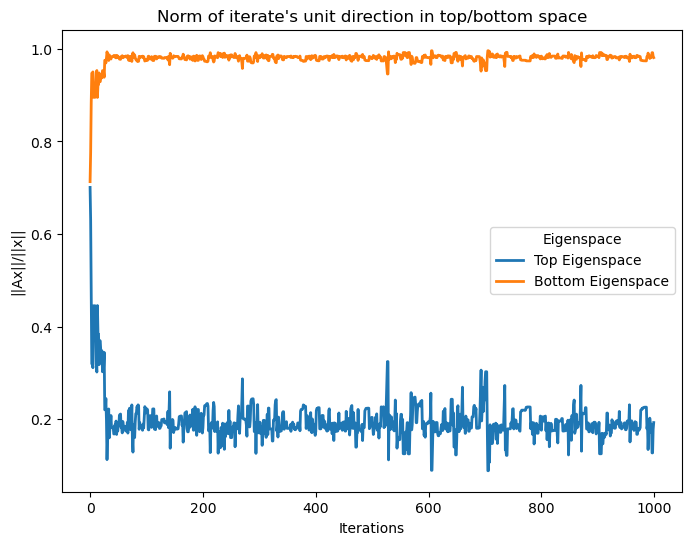

In [42]:
# Normalized projection onto major component
proj_1 = [np.linalg.norm(np.dot(np.dot(U[:, :2], Vt[:2, :]), x)) for x in normalized_iterates]

# Normalized projection onto minor component
proj_2 = [np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, proj_1, linewidth=2, label=f"Top Eigenspace")
plt.plot(nums, proj_2, linewidth=2, label=f"Bottom Eigenspace")
plt.title("Norm of iterate's unit direction in top/bottom space")
plt.xlabel("Iterations")
plt.ylabel("||Ax||/||x||")
plt.legend(title="Eigenspace")  # Add legend title

plt.show()

In [43]:
# Do iterates in the smaller subspace "spin"?
norm_proj_2 = [(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) / np.linalg.norm(np.dot(np.dot(U[:, 2:4], Vt[2:4, :]), x)) for x in normalized_iterates]     # pretty much just x again, but just to be careful!
# print(norm_proj_2)
consecutive_angles = [0 for i in range(len(norm_proj_2 ) - 1)]
for i in range(1, len(norm_proj_2)):
    consecutive_angles[i-1] = np.dot(norm_proj_2[i].T, norm_proj_2[i-1])

print(consecutive_angles)

[0.9942439988431461, 0.9998605531820819, 0.9973379949296612, 1.0, 0.9999882037544042, 0.9951612107891502, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 0.9966245300104287, 0.9989933325508218, 0.998983320806454, 0.9991210245675268, 0.9924177590105044, 0.999999867497271, 0.998651997548406, 0.9999676675907971, 0.9999922915631996, 0.9993099167509869, 1.0, 0.9727330153287314, 0.985168434113879, 0.9995220960781143, 0.9999999999999997, 0.9999430129435378, 0.9684513314454046, 0.9999999999999999, 0.9996735927343703, 0.9873739645814046, 0.9921336717783801, 0.9978579053094505, 0.999786706620644, 0.9997141844001862, 0.9969697715142936, 0.9999995859453468, 0.999112469452359, 0.9999995187558727, 0.9982053858587157, 1.0, 1.0, 1.0, 0.9995456685096404, 1.0, 0.9999940023816377, 0.9997332916713682, 0.9986044984195204, 0.9948588194030319, 0.9998129381346106, 0.9993635266364573, 0.998967852543055, 0.9999999999999999, 0.999999290966762, 0.9999978830639454, 0.9999999988161883, 0.998158323362053

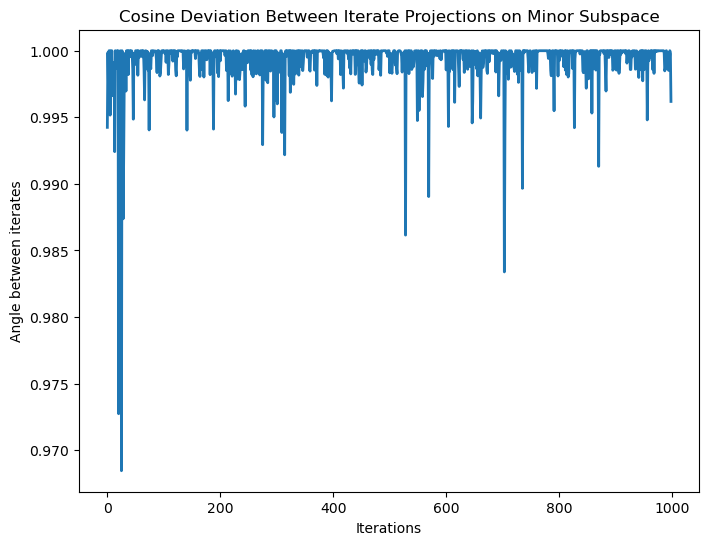

In [44]:
import matplotlib.pyplot as plt

nums = [i for i in range(len(consecutive_angles))]
plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(nums, consecutive_angles, linewidth=2)

plt.xlabel("Iterations")
plt.ylabel("Angle between iterates")
# plt.ylim(0, 1)  # Enforce y-axis range
plt.title("Cosine Deviation Between Iterate Projections on Minor Subspace")
plt.show()